# Import Libraries

Import the necessary libraries

In [1]:
!pip install folium

import pandas as pd
import numpy as np
import seaborn as sns
import folium
import requests
from bs4 import BeautifulSoup

In [2]:
!pip install geocoder
import geocoder

In [3]:
import json
from pandas.io.json import json_normalize

In [4]:
import matplotlib.pyplot as plt

# 01 Scraping Wikipedia

Get the html for the wikipedia page

In [5]:
wikiurl = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
wiki = requests.get(wikiurl).text

Using the beautifulsoup library, find the table of Canada Postal Code (with class 'wikitable sortable') and obtained the column header into headerlist

In [6]:
soup = BeautifulSoup(wiki)
table = soup.find('table', class_='wikitable sortable')

header = table.find_all('th')
headerlist = []
for x in header:
    headerlist.append(x.text[:-1])
headerlist

['Postal Code', 'Borough', 'Neighborhood']

Used looping function to obtained all the row data of the table in the form of list ROW and transform it into dataframe.

In [7]:
tabletext = table.find_all('tr')

l = []
for tr in tabletext:
    td = tr.find_all('td')
    row = [x.text[:-1] for x in td]
    l.append(row)
    
dataset = pd.DataFrame(l, columns=headerlist)
dataset.head(11)

,Postal Code,Borough,Neighborhood
0,None,None,None
1,M1A,Not assigned,
2,M2A,Not assigned,
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,"Regent Park, Harbourfront"
6,M6A,North York,"Lawrence Manor, Lawrence Heights"
7,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
8,M8A,Not assigned,
9,M9A,Etobicoke,Islington Avenue


### Data Cleaning

As instructed, remove row where data in Borough is 'Not Assigned', drop NA values, change the separators in Neighborhood from ' /' into comma

In [8]:
dataset = dataset[dataset['Borough'] !=  'Not assigned']
dataset = dataset.dropna()

dataset['Neighborhood'] = dataset['Neighborhood'].str.replace(' /',',')
dataset.head()

,Postal Code,Borough,Neighborhood
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,"Regent Park, Harbourfront"
6,M6A,North York,"Lawrence Manor, Lawrence Heights"
7,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Check if there is 'Not assigned' value in 'Neighborhood'

In [9]:
dataset[dataset['Neighborhood'] == 'Not assigned']

,Postal Code,Borough,Neighborhood


In [10]:
dataset.shape

(103, 3)

Note that Borough with multiple neighborhoods have been joined up by wikipedia.

---
---
# This ends the question for number 1, below is processing for question no 2
---
---

# 02 Extract Longitute Latitude

Read CSV from Geospatial Data

In [11]:
postalcode = pd.read_csv('http://cocl.us/Geospatial_data')
postalcode.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merge The Postal Code Data into Dataset

In [12]:
dataset = pd.merge(dataset, postalcode, how = 'left', on = 'Postal Code')
dataset.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


---
---
# This ends the question for number 2, below is processing for question no 3
---
---

The goal of the question no 3 is to cluster the neighborhood based on the types of places existing in the surroundings.  
The process is as follow :  
  1. Visualize all the neighborhood centroids on maps
  2. Extract all venues in 1 neighborhoods
  3. Repeat Task 2 using loops to get all venues in the neighborhoods
  4. Check for errors in the task 3 loop
  5. Extract Venues Count for every Neighborhoods
  6. Proceed with only neighborhoods with more than 10 Venues
  7. Group the categories of the venues into more general one
  8. Compose the final dataset by creating neighborhood tables with value counts for each venues categories types
  9. Final Dataset EDA
  10. Model Building
  11. Understanding The Clusters
  12. Final Conclusions

# 01 Extract Data Using Foursquare API

In [13]:
# Toronto Latitude & Longitude
latitude = 43.651070
longitude = -79.347015

# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(dataset['Latitude'], dataset['Longitude'], dataset['Borough'], dataset['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
#map_toronto

# 02 Extract Venues of 1 Location

to understand how the JSON works so I can create loop function for the rest

In [14]:
neighborhood_latitude = dataset.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = dataset.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = dataset.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


In [17]:
# @hidden_cell
CLIENT_ID = 'PQARHJEBARZI0UGBCTJJDA4IS50QRR3THAZ1URT0EAAO4LSI' # your Foursquare ID
CLIENT_SECRET = 'MPVTKWXJ1WNYVN4T5YNMIRFVCX1JFB5QFF2ZNIASJIKU0ZD3' # your Foursquare Secret
VERSION = '20200505' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PQARHJEBARZI0UGBCTJJDA4IS50QRR3THAZ1URT0EAAO4LSI
CLIENT_SECRET:MPVTKWXJ1WNYVN4T5YNMIRFVCX1JFB5QFF2ZNIASJIKU0ZD3


Get the top 50 locations near Parkwood

In [18]:
LIMIT = 50
radius = 500

url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ebd5a64be61c9001b86e4ce'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Parkwoods - Donalda',
  'headerFullLocation': 'Parkwoods - Donalda, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 2,
  'suggestedBounds': {'ne': {'lat': 43.757758604500005,
    'lng': -79.32343823984928},
   'sw': {'lat': 43.7487585955, 'lng': -79.33587476015072}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e8d9dcdd5fbbbb6b3003c7b',
       'name': 'Brookbanks Park',
       'location': {'address': 'Toronto',
        'lat': 43.751976046055574,
        'lng': -79.33214044722958,
        'labeledLatLngs': 

Transform the json into Dataframe

In [19]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues

col = ['venue.id','venue.name','venue.categories','venue.location.lat','venue.location.lng']
nearby_venues = nearby_venues.loc[:,col]
nearby_venues['venue.categories'] = nearby_venues['venue.categories'].apply(lambda x: x[0]['name'])
nearby_venues.loc[:,'Neighborhood'] = dataset.Neighborhood[0]
nearby_venues

,venue.id,venue.name,venue.categories,venue.location.lat,venue.location.lng,Neighborhood
0,4e8d9dcdd5fbbbb6b3003c7b,Brookbanks Park,Park,43.751976,-79.332140,Parkwoods
1,4cb11e2075ebb60cd1c4caad,Variety Store,Food & Drink Shop,43.751974,-79.333114,Parkwoods


# 3. Extract all the Venues for All the Neighborhood using methods on task 2

In [20]:
LIMIT = 50
radius = 400
venues_list = pd.DataFrame([])
errorlist = []

for neighborhood, latitude, longitude in zip(dataset.Neighborhood, dataset.Latitude, dataset.Longitude):
    #send url
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

    results = requests.get(url).json()
    
    try:
        #Transform the result into df
        venues = results['response']['groups'][0]['items']
        nearby_venues = json_normalize(venues)


        col = ['venue.id','venue.name','venue.categories','venue.location.lat','venue.location.lng']
        nearby_venues = nearby_venues.loc[:,col]
        nearby_venues['venue.categories'] = nearby_venues['venue.categories'].apply(lambda x: x[0]['name'])
        nearby_venues.loc[:,'Neighborhood'] = neighborhood

        #Append to venueslist
        venues_list = venues_list.append(nearby_venues)
    except: errorlist.append(neighborhood)

venues_list

,venue.id,venue.name,venue.categories,venue.location.lat,venue.location.lng,Neighborhood
0,4e8d9dcdd5fbbbb6b3003c7b,Brookbanks Park,Park,43.751976,-79.332140,Parkwoods
1,4cb11e2075ebb60cd1c4caad,Variety Store,Food & Drink Shop,43.751974,-79.333114,Parkwoods
0,4c633acb86b6be9a61268e34,Victoria Village Arena,Hockey Arena,43.723481,-79.315635,Victoria Village
1,4bbe904a85fbb713420d7167,Tim Hortons,Coffee Shop,43.725517,-79.313103,Victoria Village
2,4f3ecce6e4b0587016b6f30d,Portugril,Portuguese Restaurant,43.725819,-79.312785,Victoria Village
...,...,...,...,...,...,...
6,4c116455d41e76b09552310d,Subway,Sandwich Place,43.631659,-79.519001,"Mimico NW, The Queensway West, South of Bloor,..."
7,51c45641498e31c12c9d726b,RONA,Hardware Store,43.629393,-79.518320,"Mimico NW, The Queensway West, South of Bloor,..."
8,4c0313980d0e0f478225029a,7-Eleven,Convenience Store,43.629107,-79.517431,"Mimico NW, The Queensway West, South of Bloor,..."
9,4b4a2c3ff964a520507d26e3,Jim & Maria's No Frills,Grocery Store,43.631152,-79.518617,"Mimico NW, The Queensway West, South of Bloor,..."


In [21]:
#venues_list.reset_index(inplace = True)
#venues_list.drop(columns = 'index',inplace = True)
venues_list.tail()
dataset_venues = venues_list.copy()

# 4. Check for errors in the task 3 Loop

In [22]:
errorlist

['Islington Avenue',
 'West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale',
 'York Mills, Silver Hills',
 'Humber Summit',
 'Willowdale, Newtonbrook',
 'Lawrence Park',
 'Roselawn',
 'Runnymede, The Junction North',
 'Wexford, Maryvale',
 'Parkdale, Roncesvalles',
 "Milliken, Agincourt North, Steeles East, L'Amoreaux East",
 'Upper Rouge']

### Test Case 1 : Islington Avenue

In [23]:
dataset[dataset.Neighborhood == 'Islington Avenue']

,Postal Code,Borough,Neighborhood,Latitude,Longitude
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242


In [24]:
latitude = 43.667856
longitude = -79.532242
neighborhood = 'Islington Avenue'
    
url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()
    

#Transform the result into df
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)


col = ['venue.id','venue.name','venue.categories','venue.location.lat','venue.location.lng']
nearby_venues = nearby_venues.loc[:,col]
nearby_venues['venue.categories'] = nearby_venues['venue.categories'].apply(lambda x: x[0]['name'])
nearby_venues.loc[:,'Neighborhood'] = neighborhood


nearby_venues

KeyError: "None of [Index(['venue.id', 'venue.name', 'venue.categories', 'venue.location.lat',\n       'venue.location.lng'],\n      dtype='object')] are in the [columns]"

In [25]:
results['response']['groups']

[{'type': 'Recommended Places', 'name': 'recommended', 'items': []}]

Conclusions : Empty Venues

### Test Case 2 : 'New Toronto, Mimico South, Humber Bay Shores'

In [26]:
dataset[dataset.Neighborhood == 'New Toronto, Mimico South, Humber Bay Shores']

,Postal Code,Borough,Neighborhood,Latitude,Longitude
88,M8V,Etobicoke,"New Toronto, Mimico South, Humber Bay Shores",43.605647,-79.501321


In [27]:
latitude = 43.605647
longitude = -79.501321
neighborhood = 'New Toronto, Mimico South, Humber Bay Shores'
    
url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()
    

#Transform the result into df
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)


col = ['venue.id','venue.name','venue.categories','venue.location.lat','venue.location.lng']
nearby_venues = nearby_venues.loc[:,col]
nearby_venues['venue.categories'] = nearby_venues['venue.categories'].apply(lambda x: x[0]['name'])
nearby_venues.loc[:,'Neighborhood'] = neighborhood


nearby_venues

,venue.id,venue.name,venue.categories,venue.location.lat,venue.location.lng,Neighborhood
0,4f0c86b7e4b0d563f7dd6e9c,Coffee Time,Coffee Shop,43.602284,-79.499857,"New Toronto, Mimico South, Humber Bay Shores"


In [28]:
results['response']['groups']

[{'type': 'Recommended Places',
  'name': 'recommended',
  'items': [{'reasons': {'count': 0,
     'items': [{'summary': 'This spot is popular',
       'type': 'general',
       'reasonName': 'globalInteractionReason'}]},
    'venue': {'id': '4f0c86b7e4b0d563f7dd6e9c',
     'name': 'Coffee Time',
     'location': {'address': '2786 Lake Shore Blvd W',
      'crossStreet': 'at 2nd St',
      'lat': 43.6022843976276,
      'lng': -79.4998572447178,
      'labeledLatLngs': [{'label': 'display',
        'lat': 43.6022843976276,
        'lng': -79.4998572447178}],
      'distance': 392,
      'cc': 'CA',
      'city': 'Toronto',
      'state': 'ON',
      'country': 'Canada',
      'formattedAddress': ['2786 Lake Shore Blvd W (at 2nd St)',
       'Toronto ON',
       'Canada']},
     'categories': [{'id': '4bf58dd8d48988d1e0931735',
       'name': 'Coffee Shop',
       'pluralName': 'Coffee Shops',
       'shortName': 'Coffee Shop',
       'icon': {'prefix': 'https://ss3.4sqi.net/img/categor

Conclusion : Empty List

Final Conclusions = All the neighborhoods in errorlist yields no venues, hence will be dropped from the study

# 05. Extract Venues Count For Every Neighborhood

In [29]:
dataset_venues.shape

(1259, 6)

In [30]:
dataset_venues.columns = ['id','name','categories','lat','lng','neighborhood']
dataset_venues.head()

,id,name,categories,lat,lng,neighborhood
0,4e8d9dcdd5fbbbb6b3003c7b,Brookbanks Park,Park,43.751976,-79.332140,Parkwoods
1,4cb11e2075ebb60cd1c4caad,Variety Store,Food & Drink Shop,43.751974,-79.333114,Parkwoods
0,4c633acb86b6be9a61268e34,Victoria Village Arena,Hockey Arena,43.723481,-79.315635,Victoria Village
1,4bbe904a85fbb713420d7167,Tim Hortons,Coffee Shop,43.725517,-79.313103,Victoria Village
2,4f3ecce6e4b0587016b6f30d,Portugril,Portuguese Restaurant,43.725819,-79.312785,Victoria Village


In [31]:
dataset_venues['categories'].unique()

array(['Park', 'Food & Drink Shop', 'Hockey Arena', 'Coffee Shop',
       'Portuguese Restaurant', 'French Restaurant', 'Pizza Place',
       'Bakery', 'Breakfast Spot', 'Distribution Center', 'Spa',
       'Restaurant', 'Gym / Fitness Center', 'Pub', 'Yoga Studio',
       'Theater', 'Electronics Store', 'Bank', 'Hotel',
       'Health Food Store', 'Boutique', 'Furniture / Home Store',
       'Clothing Store', 'Accessories Store', 'Event Space',
       "Women's Store", 'Gift Shop', 'Shoe Store', 'Italian Restaurant',
       'Fried Chicken Joint', 'Sandwich Place', 'Café',
       'Vegetarian / Vegan Restaurant', 'Fast Food Restaurant',
       'Tennis Court', 'Gastropub', 'Pharmacy', 'Pet Store',
       'Intersection', 'Tea Room', 'Comic Shop', 'Plaza', 'Burrito Place',
       'Music Venue', 'Thai Restaurant', 'Mexican Restaurant',
       'Steakhouse', 'Art Gallery', 'Ramen Restaurant',
       'Sporting Goods Shop', 'Burger Joint', 'Diner', 'Shopping Mall',
       'College Rec Center', '

In [32]:
dataset_vcount = pd.DataFrame(dataset_venues.groupby('neighborhood')['id'].agg(len))
dataset_vcount.head()

,id
neighborhood,
Agincourt,4
"Alderwood, Long Branch",7
"Bathurst Manor, Wilson Heights, Downsview North",19
Bayview Village,1
"Bedford Park, Lawrence Manor East",22


In [33]:
dataset_neighborhood = pd.merge(dataset, dataset_vcount, how = 'left', left_on='Neighborhood', right_on ='neighborhood' )
dataset_neighborhood.rename(columns = {'id':'Venues_count'}, inplace = True)
dataset_neighborhood.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Venues_count
0,M3A,North York,Parkwoods,43.753259,-79.329656,2.0
1,M4A,North York,Victoria Village,43.725882,-79.315572,5.0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,19.0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,10.0
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,15.0


In [34]:
dataset_neighborhood['Venues_count']=dataset_neighborhood['Venues_count'].fillna(0)

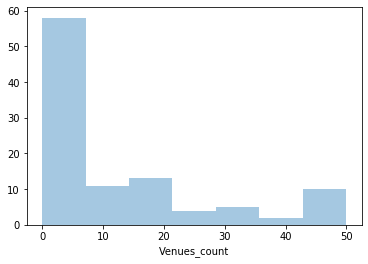

In [35]:
sns.distplot(dataset_neighborhood['Venues_count'], kde=False)

In [36]:
dataset_neighborhood[dataset_neighborhood['Venues_count'] > 10].head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Venues_count
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,19.0
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,15.0
7,M3B,North York,Don Mills,43.745906,-79.352188,18.0
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,50.0
13,M3C,North York,Don Mills,43.725900,-79.340923,18.0


# 06. Proceed With neighborhood with more than 10 Venues Count

In [37]:
dataset_neighborhood = dataset_neighborhood[dataset_neighborhood['Venues_count'] > 10]

In [38]:
# Toronto Latitude & Longitude
latitude = 43.651070
longitude = -79.347015

# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(dataset_neighborhood['Latitude'], dataset_neighborhood['Longitude'], dataset_neighborhood['Borough'], dataset_neighborhood['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Chosen Neighborhood is mostly concentrated in City Center

# 07. Group the category into General Categories For Clustering

Currently categories for every places have a very detailed categories, i.e spanish restaurant, chinese restaurants, bakery. Clustering them based on the category will be ver difficult. hence we want to generalize them into more general cluster. For example all those restaurants, should be labelled as restaurants only, regardless of their type.

In [39]:
feat_venues= dataset_venues[dataset_venues['neighborhood'].isin(dataset_neighborhood['Neighborhood'])]
feat_venues.head()

,id,name,categories,lat,lng,neighborhood
0,54ea41ad498e9a11e9e13308,Roselle Desserts,Bakery,43.653447,-79.362017,"Regent Park, Harbourfront"
1,53b8466a498e83df908c3f21,Tandem Coffee,Coffee Shop,43.653559,-79.361809,"Regent Park, Harbourfront"
2,4ae5b91ff964a520a6a121e3,Morning Glory Cafe,Breakfast Spot,43.653947,-79.361149,"Regent Park, Harbourfront"
3,574c229e498ebb5c6b257902,Cooper Koo Family YMCA,Distribution Center,43.653249,-79.358008,"Regent Park, Harbourfront"
4,50760559e4b0e8c7babe2497,Body Blitz Spa East,Spa,43.654735,-79.359874,"Regent Park, Harbourfront"


In [40]:
feat_venues['categories'].unique()

array(['Bakery', 'Coffee Shop', 'Breakfast Spot', 'Distribution Center',
       'Spa', 'Restaurant', 'Gym / Fitness Center', 'Park', 'Pub',
       'Yoga Studio', 'Theater', 'Electronics Store', 'Bank', 'Hotel',
       'Health Food Store', 'Italian Restaurant', 'Fried Chicken Joint',
       'Sandwich Place', 'Café', 'Vegetarian / Vegan Restaurant',
       'Tennis Court', 'Clothing Store', 'Tea Room', 'Comic Shop',
       'Plaza', 'Burrito Place', 'Music Venue', 'Thai Restaurant',
       'Mexican Restaurant', 'Steakhouse', 'Art Gallery',
       'Ramen Restaurant', 'Sporting Goods Shop', 'Burger Joint', 'Diner',
       'Shopping Mall', 'College Rec Center', 'Middle Eastern Restaurant',
       'Tanning Salon', 'Fast Food Restaurant', 'New American Restaurant',
       'Bar', 'Lake', 'Bookstore', 'Modern European Restaurant',
       'Movie Theater', 'Japanese Restaurant', 'Gastropub',
       'Bubble Tea Shop', 'Ethiopian Restaurant', 'Lounge',
       'Cosmetics Shop', 'Gym', 'Discount Store'

The general category we are using comes from foursquare groupings, where more detailed category have their parents category. Details can be seen here. https://developer.foursquare.com/docs/build-with-foursquare/categories/

In [41]:
url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
raw = requests.get(url).json()

In [42]:
results = raw['response']['categories']
df = json_normalize(results)
df.head()

,id,name,pluralName,shortName,categories,icon.prefix,icon.suffix
0,4d4b7104d754a06370d81259,Arts & Entertainment,Arts & Entertainment,Arts & Entertainment,"[{'id': '56aa371be4b08b9a8d5734db', 'name': 'A...",https://ss3.4sqi.net/img/categories_v2/arts_en...,.png
1,4d4b7105d754a06372d81259,College & University,Colleges & Universities,College & Education,"[{'id': '4bf58dd8d48988d198941735', 'name': 'C...",https://ss3.4sqi.net/img/categories_v2/educati...,.png
2,4d4b7105d754a06373d81259,Event,Events,Event,"[{'id': '52f2ab2ebcbc57f1066b8b3b', 'name': 'C...",https://ss3.4sqi.net/img/categories_v2/event/d...,.png
3,4d4b7105d754a06374d81259,Food,Food,Food,"[{'id': '503288ae91d4c4b30a586d67', 'name': 'A...",https://ss3.4sqi.net/img/categories_v2/food/de...,.png
4,4d4b7105d754a06376d81259,Nightlife Spot,Nightlife Spots,Nightlife,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",https://ss3.4sqi.net/img/categories_v2/nightli...,.png


In [43]:
catlist =[]
for i in range(0,df['name'].size):
    for lib in df.loc[i,'categories']:
        catlist.append([df.loc[i,'name'],lib['name']])
        
catlist = pd.DataFrame(catlist, columns = ['bigcat','categories'])

In [44]:
catlist.head()
catlist['bigcat'].unique()

array(['Arts & Entertainment', 'College & University', 'Event', 'Food',
       'Nightlife Spot', 'Outdoors & Recreation',
       'Professional & Other Places', 'Residence', 'Shop & Service',
       'Travel & Transport'], dtype=object)

In [45]:
feat_venues = pd.merge(feat_venues,catlist, how='left',on='categories')
feat_venues.head()

,id,name,categories,lat,lng,neighborhood,bigcat
0,54ea41ad498e9a11e9e13308,Roselle Desserts,Bakery,43.653447,-79.362017,"Regent Park, Harbourfront",Food
1,53b8466a498e83df908c3f21,Tandem Coffee,Coffee Shop,43.653559,-79.361809,"Regent Park, Harbourfront",Food
2,4ae5b91ff964a520a6a121e3,Morning Glory Cafe,Breakfast Spot,43.653947,-79.361149,"Regent Park, Harbourfront",Food
3,574c229e498ebb5c6b257902,Cooper Koo Family YMCA,Distribution Center,43.653249,-79.358008,"Regent Park, Harbourfront",Professional & Other Places
4,50760559e4b0e8c7babe2497,Body Blitz Spa East,Spa,43.654735,-79.359874,"Regent Park, Harbourfront",Shop & Service


Unfortunately, there are some not within the list. we have to do it manually

In [46]:
feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Restaurant'), 'Food', feat_venues['bigcat'])
feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Food'), 'Food', feat_venues['bigcat'])
feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Ice Cream'), 'Food', feat_venues['bigcat'])
feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Burrito'), 'Food', feat_venues['bigcat'])
feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Taco'), 'Food', feat_venues['bigcat'])
feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Poke'), 'Food', feat_venues['bigcat'])
feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Cheese'), 'Food', feat_venues['bigcat'])
feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Gourmet'), 'Food', feat_venues['bigcat'])
feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Yogurt'), 'Food', feat_venues['bigcat'])
feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Butcher'), 'Food', feat_venues['bigcat'])
feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Noodle'), 'Food', feat_venues['bigcat'])

feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Store'), 'Shop & Service', feat_venues['bigcat'])
feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Supermarket'), 'Shop & Service', feat_venues['bigcat'])
feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Boutique'), 'Shop & Service', feat_venues['bigcat'])
feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Market'), 'Shop & Service', feat_venues['bigcat'])
feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Grocery'), 'Shop & Service', feat_venues['bigcat'])


feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Gym'), 'Outdoors & Recreation', feat_venues['bigcat'])
feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Yoga Studio'), 'Outdoors & Recreation', feat_venues['bigcat'])
feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Court'), 'Outdoors & Recreation', feat_venues['bigcat'])
feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Skating Rink'), 'Outdoors & Recreation', feat_venues['bigcat'])
feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Studio'), 'Outdoors & Recreation', feat_venues['bigcat'])
feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Stadium'), 'Outdoors & Recreation', feat_venues['bigcat'])
feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Outdoor'), 'Outdoors & Recreation', feat_venues['bigcat'])
feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Monument'), 'Outdoors & Recreation', feat_venues['bigcat'])
feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Martial'), 'Outdoors & Recreation', feat_venues['bigcat'])

feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Pub'), 'Nightlife Spot', feat_venues['bigcat'])
feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Bar'), 'Nightlife Spot', feat_venues['bigcat'])
feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Speakeasy'), 'Nightlife Spot', feat_venues['bigcat'])

feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Theater'), 'Arts & Entertainment', feat_venues['bigcat'])
feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Jazz Club'), 'Arts & Entertainment', feat_venues['bigcat'])
feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Opera House'), 'Arts & Entertainment', feat_venues['bigcat'])
feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Museum'), 'Arts & Entertainment', feat_venues['bigcat'])


feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('College'), 'College & University', feat_venues['bigcat'])

feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Airport'), 'Travel & Transport', feat_venues['bigcat'])
feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Plane'), 'Travel & Transport', feat_venues['bigcat'])

feat_venues['bigcat'] = np.where(feat_venues['categories'].str.contains('Neighborhood'), 'Residence', feat_venues['bigcat'])

In [47]:
feat_venues[feat_venues['bigcat'].isnull()]

,id,name,categories,lat,lng,neighborhood,bigcat


In [48]:
feat_venues.head()

,id,name,categories,lat,lng,neighborhood,bigcat
0,54ea41ad498e9a11e9e13308,Roselle Desserts,Bakery,43.653447,-79.362017,"Regent Park, Harbourfront",Food
1,53b8466a498e83df908c3f21,Tandem Coffee,Coffee Shop,43.653559,-79.361809,"Regent Park, Harbourfront",Food
2,4ae5b91ff964a520a6a121e3,Morning Glory Cafe,Breakfast Spot,43.653947,-79.361149,"Regent Park, Harbourfront",Food
3,574c229e498ebb5c6b257902,Cooper Koo Family YMCA,Distribution Center,43.653249,-79.358008,"Regent Park, Harbourfront",Professional & Other Places
4,50760559e4b0e8c7babe2497,Body Blitz Spa East,Spa,43.654735,-79.359874,"Regent Park, Harbourfront",Shop & Service


# Visualize the data

In [49]:
colormap = {
           'Arts & Entertainment':'red',
            'College & University':'orange',
            'Food': 'yellow',
            'Nightlife Spot':'green',
            'Outdoors & Recreation':'blue',
            'Professional & Other Places':'violet',
            'Residence':'purple',
            'Shop & Service':'cyan',
            'Travel & Transport':'magenta'
           }

tmp = feat_venues.copy()
tmp.loc[:,'color'] = tmp['bigcat'].map(colormap)
tmp.head()

# Toronto Latitude & Longitude
latitude = 43.651070
longitude = -79.347015

# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

col ='Venues_count'
# add markers to map
for lat, lng, name, category, color in zip(tmp['lat'], tmp['lng'], tmp['name'],
                                                 tmp['categories'], tmp['color']):
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color= color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

# 08. Composing Final Dataset

In [50]:
venues_category = pd.crosstab(index = feat_venues.neighborhood, columns = feat_venues.bigcat)
venues_category.head()

bigcat,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
neighborhood,,,,,,,,,
"Bathurst Manor, Wilson Heights, Downsview North",0,0,11,0,0,0,0,8,0
"Bedford Park, Lawrence Manor East",0,0,16,3,0,0,0,3,0
Berczy Park,1,0,7,5,2,0,0,4,0
"Brockton, Parkdale Village, Exhibition Place",0,0,9,4,2,0,0,2,0
Business reply mail Processing Centre,0,0,4,1,3,0,0,6,1


In [51]:
final_dataset = pd.merge(dataset_neighborhood, venues_category, how = 'left',left_on='Neighborhood',right_on='neighborhood')
final_dataset.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Venues_count,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,19.0,1,0,8,1,3,1,0,4,1
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,15.0,0,0,12,0,1,1,0,1,0
2,M3B,North York,Don Mills,43.745906,-79.352188,18.0,0,0,11,0,2,0,0,5,0
3,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,50.0,4,1,30,2,2,0,0,10,1
4,M3C,North York,Don Mills,43.725900,-79.340923,18.0,0,0,11,0,2,0,0,5,0


Convert the count on each category into percentage

In [52]:
cat = ['Arts & Entertainment', 'College & University', 'Food',
       'Nightlife Spot', 'Outdoors & Recreation',
       'Professional & Other Places', 'Residence', 'Shop & Service',
       'Travel & Transport']

for i in cat:
    final_dataset[i] = final_dataset[i] / final_dataset['Venues_count']
    
final_dataset.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Venues_count,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,19.0,0.052632,0.00,0.421053,0.052632,0.157895,0.052632,0.0,0.210526,0.052632
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,15.0,0.000000,0.00,0.800000,0.000000,0.066667,0.066667,0.0,0.066667,0.000000
2,M3B,North York,Don Mills,43.745906,-79.352188,18.0,0.000000,0.00,0.611111,0.000000,0.111111,0.000000,0.0,0.277778,0.000000
3,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,50.0,0.080000,0.02,0.600000,0.040000,0.040000,0.000000,0.0,0.200000,0.020000
4,M3C,North York,Don Mills,43.725900,-79.340923,18.0,0.000000,0.00,0.611111,0.000000,0.111111,0.000000,0.0,0.277778,0.000000


# 09 Final Dataset EDA

Residences, Professional & Other Places & College & University indicates very low proportion. Might need joining into "other" group

In [53]:
final_dataset.describe()

,Latitude,Longitude,Venues_count,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
mean,43.680630,-79.387742,28.666667,0.031152,0.002564,0.566720,0.079793,0.068636,0.004085,0.001880,0.209281,0.035889
std,0.046341,0.042623,14.424638,0.040689,0.013122,0.162440,0.061900,0.057101,0.013921,0.006831,0.148702,0.133353
min,43.628841,-79.520999,11.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,43.649500,-79.407086,18.000000,0.000000,0.000000,0.464115,0.040000,0.032292,0.000000,0.000000,0.118824,0.000000
50%,43.662696,-79.382280,22.000000,0.000000,0.000000,0.611111,0.080000,0.060000,0.000000,0.000000,0.166667,0.000000
75%,43.704847,-79.362044,45.000000,0.052632,0.000000,0.687500,0.104054,0.111111,0.000000,0.000000,0.305556,0.023514
max,43.799525,-79.315572,50.000000,0.166667,0.080000,0.800000,0.263158,0.200000,0.066667,0.033333,0.545455,0.833333


Checking 'Residences', 'Professional & Other Places' & 'College & University'

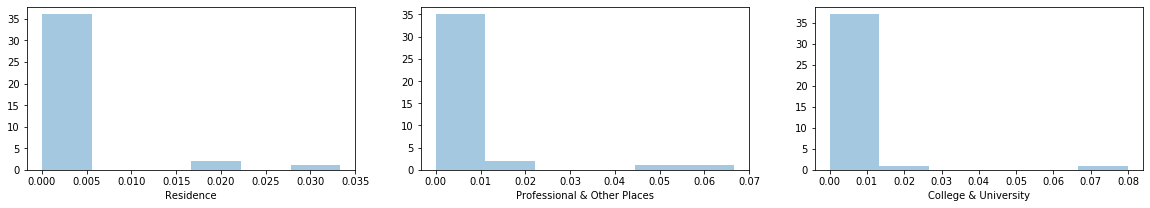

In [54]:
plt.figure(figsize=(20,3))
plt.subplot(1,3,1)
sns.distplot(final_dataset['Residence'], kde = False)
plt.subplot(1,3,2)
sns.distplot(final_dataset['Professional & Other Places'], kde = False)
plt.subplot(1,3,3)
sns.distplot(final_dataset['College & University'], kde = False)

Majority of the neighborhood has very low proportion of these categories
Decision = Combine 'Residences', 'Professional & Other Places' & 'College & University' into 1 category ('Others'

In [55]:
final_dataset.loc[:,'Others'] = final_dataset['Residence'] + final_dataset['Professional & Other Places'] + final_dataset['College & University']
final_dataset.drop(columns = ['Residence', 'Professional & Other Places','College & University'], inplace = True)
final_dataset.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Venues_count,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Others
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,19.0,0.052632,0.421053,0.052632,0.157895,0.210526,0.052632,0.052632
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,15.0,0.000000,0.800000,0.000000,0.066667,0.066667,0.000000,0.066667
2,M3B,North York,Don Mills,43.745906,-79.352188,18.0,0.000000,0.611111,0.000000,0.111111,0.277778,0.000000,0.000000
3,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,50.0,0.080000,0.600000,0.040000,0.040000,0.200000,0.020000,0.020000
4,M3C,North York,Don Mills,43.725900,-79.340923,18.0,0.000000,0.611111,0.000000,0.111111,0.277778,0.000000,0.000000


Explore the Distribution of Function in Neighborhood

In [56]:
# Toronto Latitude & Longitude
latitude = 43.651070
longitude = -79.347015

# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

col ='Food'
# add markers to map
for lat, lng, borough, neighborhood, size in zip(final_dataset['Latitude'], final_dataset['Longitude'], final_dataset['Borough'],
                                                 final_dataset['Neighborhood'], final_dataset[col]):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=size*100,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

# 05 Model Buildings

## Deciding The Number of K

In [57]:
final_dataset.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Venues_count,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Others
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,19.0,0.052632,0.421053,0.052632,0.157895,0.210526,0.052632,0.052632
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,15.0,0.000000,0.800000,0.000000,0.066667,0.066667,0.000000,0.066667
2,M3B,North York,Don Mills,43.745906,-79.352188,18.0,0.000000,0.611111,0.000000,0.111111,0.277778,0.000000,0.000000
3,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,50.0,0.080000,0.600000,0.040000,0.040000,0.200000,0.020000,0.020000
4,M3C,North York,Don Mills,43.725900,-79.340923,18.0,0.000000,0.611111,0.000000,0.111111,0.277778,0.000000,0.000000


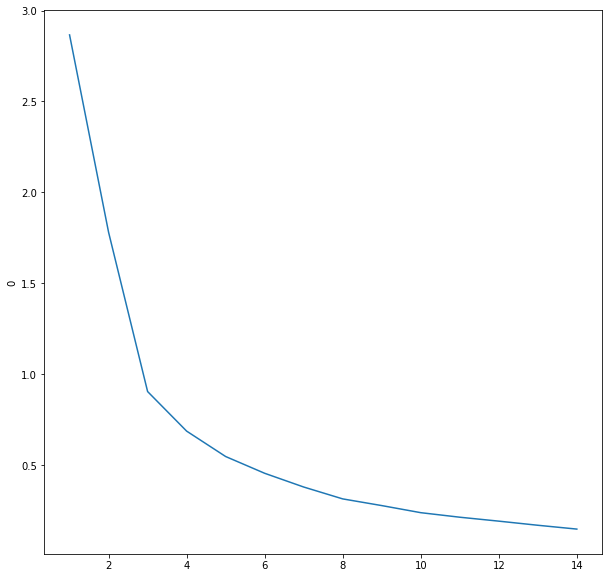

In [58]:
#Import dataset
X = final_dataset.loc[:,['Arts & Entertainment','Food','Nightlife Spot','Outdoors & Recreation','Shop & Service','Travel & Transport','Others']]

#Import the Machine
from sklearn.cluster import KMeans

#Determine the amount of cluster
wcss = []
for i in range (1,15):
    cluster = KMeans(n_clusters = i, init = 'k-means++', random_state = None)
    cluster.fit(X)
    wcss.append(cluster.inertia_)
wcss = pd.DataFrame(wcss)
temp = []
for i in range(1,13):
    temp.append((wcss.iloc[i-1,0] - wcss.iloc[i,0]) / ( wcss.iloc[i+1,0] - wcss.iloc[i,0]))
temp.insert(0,0)
temp.insert(len(temp),0)
wcss['angle magnitude']= temp
wcss.index = np.arange(1,len(wcss)+1)

plt.figure(figsize = (10,10))
sns.lineplot(x = range(1,15), y = wcss[0])

Decision = K = 5

In [59]:
cluster = KMeans(n_clusters = 5, init = 'k-means++', random_state = 1)
y = cluster.fit_predict(X)

# 11. Understanding the Clusters

In [60]:
final_dataset.loc[:,'Cluster_group'] = y
final_dataset.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Venues_count,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Others,Cluster_group
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,19.0,0.052632,0.421053,0.052632,0.157895,0.210526,0.052632,0.052632,3
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,15.0,0.000000,0.800000,0.000000,0.066667,0.066667,0.000000,0.066667,4
2,M3B,North York,Don Mills,43.745906,-79.352188,18.0,0.000000,0.611111,0.000000,0.111111,0.277778,0.000000,0.000000,4
3,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,50.0,0.080000,0.600000,0.040000,0.040000,0.200000,0.020000,0.020000,4
4,M3C,North York,Don Mills,43.725900,-79.340923,18.0,0.000000,0.611111,0.000000,0.111111,0.277778,0.000000,0.000000,4


In [61]:
final_dataset['Cluster_group'].value_counts()

4    16
0     9
1     8
3     5
2     1
Name: Cluster_group, dtype: int64

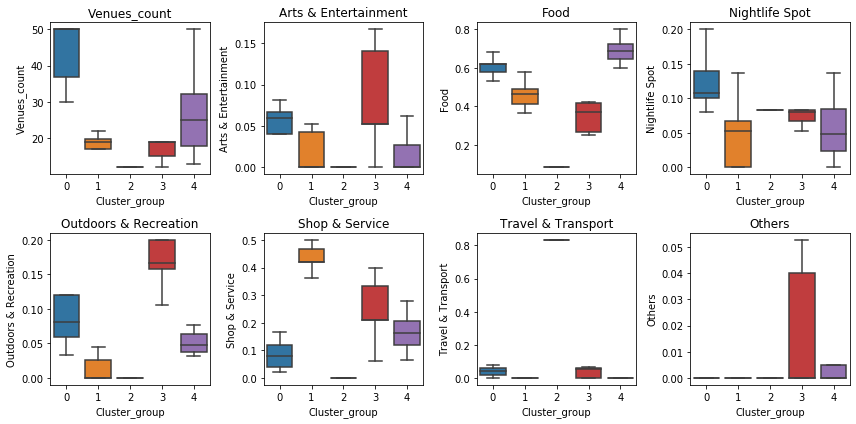

In [62]:
inq = ['Venues_count','Arts & Entertainment','Food','Nightlife Spot','Outdoors & Recreation','Shop & Service','Travel & Transport','Others']

plt.figure(figsize = (12,6))
for i,inq in enumerate(inq):
    plt.subplot(2,4,i+1)
    plt.title(inq)
    sns.boxplot(x='Cluster_group', y = inq, data = final_dataset, showfliers = False)
    plt.tight_layout()

Conclusion of Clustering

Findings = Cluster 0 have lots of venues, despite venues_count is not used in clustering

Cluster 0 : Food Dominated Neighborhood (>60%) with lower percentage of shop&services
Cluster 1 : Neighborhood with majority of places are travel & transport category, probably a transit area
Cluster 2 : Neighborhood with dominated with shopes and fair amount of percentage on food
Cluster 3 : Compared to others, have higher proportion of outdoors rec & arts entertainment
Cluster 4 : Larger proportions of outdoors&rec as well as others functions

In [63]:
colormap = {
           0:'blue',
            1:'orange',
            2: 'green',
            3:'red',
            4:'yellow'
           }

tmp = final_dataset.copy()
tmp.loc[:,'color'] = tmp['Cluster_group'].map(colormap)
tmp.head()

# Toronto Latitude & Longitude
latitude = 43.651070
longitude = -79.347015

# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

col ='Venues_count'
# add markers to map
for lat, lng, name, group,color in zip(tmp['Latitude'], tmp['Longitude'], tmp['Neighborhood'], tmp['Cluster_group'],
                                                 tmp['color']):
    label = '{}, {}'.format(name, group)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=15,
        popup=label,
        color= color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

# Final Conclusion

Cluster 0(blue) is identified as food dominated zones and cluster 3(red) identified as more entertainment-filled areas. Both characteristics are commonly found in downtown or city centers, which is validated by the models. Cluster 2 (green) have less proportions of entertainments and nightlifes, with large proportions in stores, suggesting a more residential kind of neighborhood. From the map above, it is in fact true that green areas located further away from the core downtown. As the only neighborhood in cluster 1 (orange) is in airport area, it makes complete sense that cluster 1 have high proportions of transport functions. Cluster 4 (yellow) is located somewhat different from all other clusters. Boxplot visualizations also indicates slight peculiarity as amongst other categories, cluster 4 has low proportions and a very dominated proportions on Others & outdoor recs functions. 